In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import umap
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# local imports
import geneformer_utils as gtu

sns.set_style('white')

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
reload(gtu)
torch.cuda.empty_cache()
num_cells = 10000

"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_muscle.dataset"
df = gtu.load_data_as_dataframe(data_path, num_cells=num_cells, shuffle=True)

# convert into arrow dataset
data = Dataset.from_pandas(df)

# useful for later
features = df.columns.to_list()
features.remove("input_ids")

print(f"{df.shape=}")
df.head()

df.shape=(10000, 13)


,input_ids,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender,length
0,"[2701, 9009, 7352, 61, 10920, 15990, 15987, 18...",Muscle,10X,TSP2,rectusabdominus,11002.0,3038,mesenchymal stem cell,mesenchymal stem cell,True,stromal,female,2048
1,"[6348, 5069, 808, 17626, 12018, 9748, 6489, 15...",Muscle,10X,TSP2,rectusabdominus,4456.0,1685,capillary endothelial cell,capillary endothelial cell,True,endothelial,female,1562
2,"[14816, 3072, 10691, 5776, 7283, 1683, 15169, ...",Muscle,smartseq2,TSP2,diaphragm,163457.0,1551,endothelial cell of vascular tree,endothelial cell of vascular tree,True,endothelial,female,1358
3,"[9009, 376, 18367, 6489, 454, 16916, 2225, 942...",Muscle,10X,TSP14,Abdomen,11555.0,3121,mesenchymal stem cell,mesenchymal stem cell,True,stromal,male,2048
4,"[16916, 9009, 5080, 10920, 877, 4923, 2124, 79...",Muscle,10X,TSP2,rectusabdominus,11517.0,2963,mesenchymal stem cell,mesenchymal stem cell,True,stromal,female,2048


In [3]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
print(f"{embs.shape=}")
embs.head()

100%|██████████| 1000/1000 [10:10<00:00,  1.64it/s]

embs.shape=(10000, 512)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.010958,-0.087159,1.652395,-0.083996,-0.024927,-0.107489,-0.667254,0.034595,0.000294,0.397330,...,0.434004,-0.232511,0.154670,-0.428088,0.117187,0.177142,0.237579,0.097980,0.381286,-0.448270
1,0.003885,0.042521,1.681913,-0.416512,-0.240424,-0.412216,-0.678460,0.047384,-0.002755,0.281365,...,0.445421,0.100039,0.151362,-0.537323,0.211351,-0.122623,0.066097,0.340459,0.485910,-0.395220
2,-0.259811,-0.407567,1.509599,-0.155009,0.007000,-0.161127,0.047335,-0.295696,0.348368,0.755738,...,0.273619,-0.589696,0.137482,0.208909,0.113663,-0.071778,-0.101334,-0.414200,0.222108,-0.135593
3,0.122791,0.191594,1.603823,-0.043077,-0.002565,-0.128820,-0.770756,0.213566,-0.030185,0.312940,...,0.555596,-0.098368,0.145776,-0.397160,0.185694,0.161895,0.285428,-0.159241,0.332957,-0.554396
4,0.002351,0.029626,1.663690,-0.030830,0.010237,-0.152045,-0.697064,0.051871,-0.075700,0.316962,...,0.473939,-0.091035,0.165517,-0.325740,0.051812,0.091567,0.295048,0.203928,0.417891,-0.448658


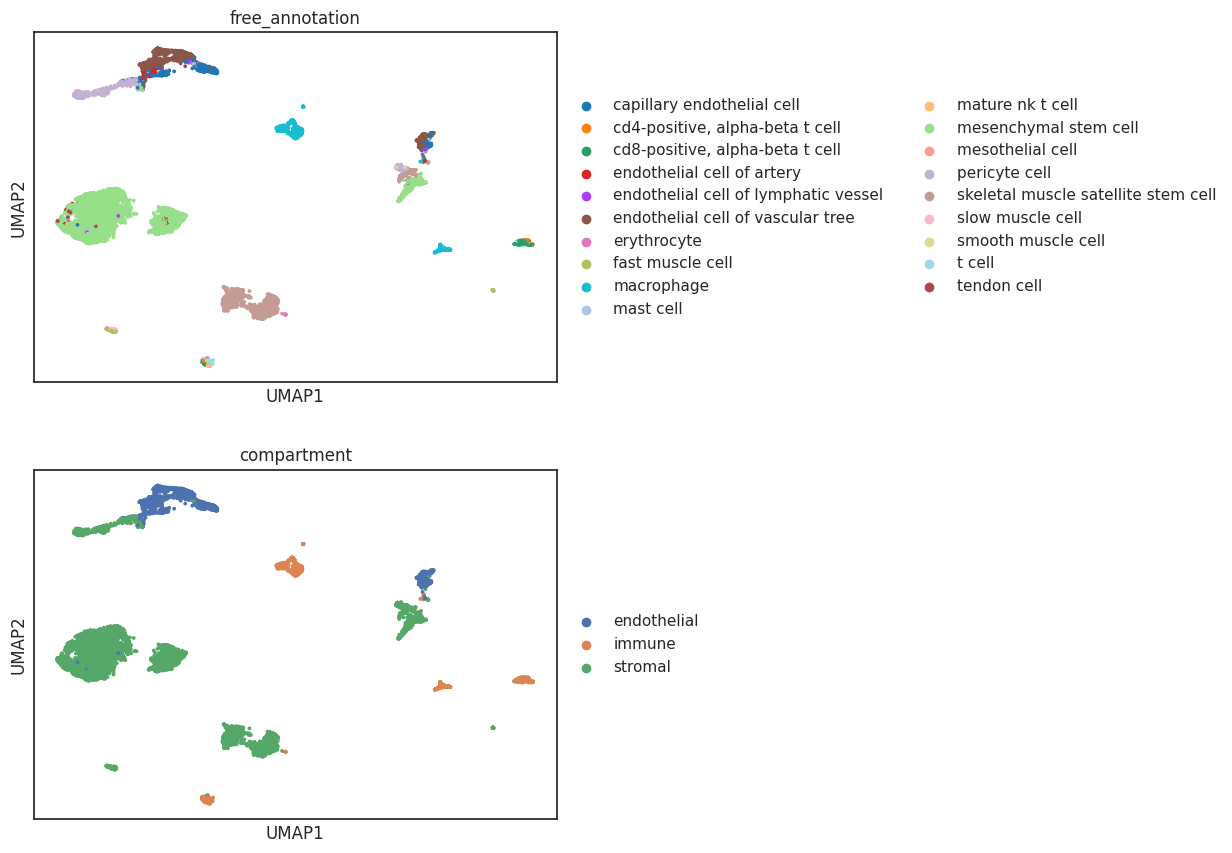

AnnData object with n_obs × n_vars = 10000 × 512
    obs: 'input_ids', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'length'
    uns: 'pca', 'neighbors', 'umap', 'free_annotation_colors', 'compartment_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [6]:
# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["free_annotation", "compartment"],
    ncols=1,
    size=30,
)

adata

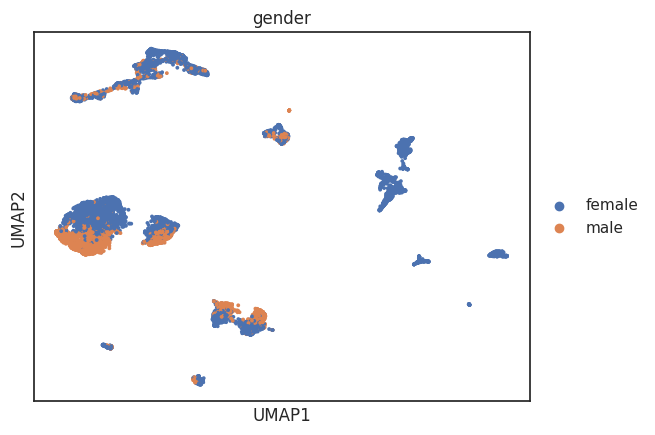

In [8]:
sc.pl.umap(
    adata,
    color=["gender"],
    ncols=1,
    size=30,
)

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Original Geneformer Extraction

In [ ]:
torch.cuda.empty_cache()

n_cells = 10000
# 0 for last layer, -1 for second to last
layer = -1

# initiate EmbExtractor
embex = EmbExtractor(model_type="Pretrained",
                     num_classes=0,
                     max_ncells=n_cells,
                     emb_mode='cell',
                     emb_layer=layer,
                     emb_label=features,
                     forward_batch_size=30,
                     nproc=16,
                      )

# extracts embedding from input data
embs = embex.extract_embs(model,
                          data_path,
                          outpath,
                          "test")

embs.head()

In [ ]:
# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["free_annotation"],
    ncols=1,
    size=30,
)

adata

In [ ]:
# break

In [ ]:
break

# in-memory embedding extraction

In [ ]:
reload(gtu)
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model = gtu.load_model(model_path)
type(model)

In [ ]:
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.dataset"
data = load_from_disk(data_path)
type(data)

In [ ]:
reload(gtu)
token_path = gtu.DEFAULT_TOKEN_PATH
tokens = gtu.load_pickle(token_path)
print(tokens.get("<pad>"))
# len(tokens)

In [ ]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
embs.head()

# a simple perturbation example



In [ ]:
token_data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/token_mappings.csv"
token_df = pd.read_csv(token_data_path)
token_df.head()

In [ ]:
# extract the yamanaka factors
query_genes = [
    'POU5F1', # oct4
    'SOX2',
    'KLF4',
    'MYC'   
]

genes = token_df[token_df['gene_name'].isin(query_genes)]
force_tokens = genes['token_id'].to_list()
genes

In [ ]:
# convert the arrow dataset to a dataframe
raw_data = data.to_pandas()
raw_data['type'] = 'raw'
print(raw_data[['input_ids']].head())
print()

# perturb the cells
perturbed = raw_data.copy()
perturbed['type'] = 'perturbed'
perturbed['input_ids'] = perturbed['input_ids'].apply(lambda x: list(force_tokens) + list(x)[:len(x) - len(force_tokens)])
print(perturbed[['input_ids']].head())

# join the data back together
df = pd.concat([raw_data, perturbed])
print(f"{df.shape=}")
df.head()

In [ ]:
# convert back into arrow dataset
new_data = Dataset.from_pandas(df)

# extract embeddings 
embs = gtu.extract_embedding_in_mem(model, new_data)
embs.head()

In [ ]:
reload(gtu)
adata = gtu.make_embedding_anndata(embs, df)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["type"],
    ncols=1,
    # Setting a smaller point size to get prevent overlap
    size=30,
)

# Archive

In [ ]:
break

# Neighbor Graph (no PCA of embeddings)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["cell_type", "dataset"],
    n_cols=1,
    # Setting a smaller point size to get prevent overlap
    size=10,
)

In [ ]:
break

In [ ]:
comp_1 = 4
comp_2 = 5

sns.scatterplot(data=embs,
                x=comp_1,
                y=comp_2,
                ec='none',
                lw=0.1,
                alpha=0.9,
                hue='dataset',
                s=5)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
sc.tl.pca(adata, n_comps=5)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="cell_type",
    # Setting a smaller point size to get prevent overlap
    size=10,
)

In [ ]:
break

In [ ]:
sc.tl.leiden(adata, n_iterations=2)
sc.pl.umap(adata, color=["leiden"])

In [ ]:
break

In [ ]:
sns.scatterplot(data=embs,
                x=0,
                y=1,
                hue='dataset',
                s=10)

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
break

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=21)
sc.tl.umap(adata, min_dist=0.2)

adata

In [ ]:
sc.pl.umap(adata, 
           color=['dataset'])

In [ ]:
break

In [ ]:
df = embs.copy()

sns.scatterplot(data=df,  
                x=0,
                y=2,
                alpha=0.6,
                s=10,
                palette="Set1",
                # legend=False,
                hue='dataset')

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1))
